## Analiza dokładności i czasu uczenia dla Big Data - porównanie metody gradientu prostego, metody gradientu stochastycznego i zmniejszenia zbioru uczącego.

Imię, nazwisko: Krzysztof Jarek.

Kierunek, semestr: IT II, 2.

Data oddania: 26.01.2023.

<center><img src='pictures/comparison.png' width=700 height=500 /></center>

## Cele:

* implementacja algorytmów realizujących metody Gradient Descent (GD) i Stochastic Gradient Descent (SGD),
* wykorzystanie pierwszego algorytmu również dla przebadania zagadnienia związanego z *undersampling'iem*,
* przeprowadzenie analizy porównawczej działania implementacji ze względu na czas wykonania i dokładność.

### Problem:

**Metoda gradientu prostego** (też metoda najszybszego spadku, ang. Gradient Descent) sprowadza się do koncepcji iteracyjnego algorytmu optymalizacji pierwszego rzędu, służącego do znajdowania lokalnego minimum funkcji różniczkowalnej. Upraszczając, głowna idea algorytmu sprowadza się do tego, aby powtarzane były kroki w kierunku przeciwnym do gradientu (lub przybliżonego gradientu) funkcji w bieżącym punkcie, ponieważ jest to kierunek tzw. najszybszego spadku, w efekcie czego iteracyjnie przybliżane będzie poszukiwane ekstremum funkcji.

Algorytm, czy też wersje będące jego bliższym lub dalszym rozwininięciem, są obecnie powszechnie stosowane w ramach  badań uczenia maszynowego (ML). Wśród rozwiązań opracowanych w ostatniej dekadzie wyróżniały się te jego wersje których zbudowanie wiązało się z dodatkowym wykorzystaniem metod stochatycznych.

Nawiązując do tej problematyki, w podejmowanym badaniu bazowy algorytm został poddany porównaniu z dwoma wybranym wersjom zmodyfikowanym pod względem wydajności i precyzji: jednej dodatkowo implementującej próbkowanie stochatyczne, drugiej wykorzystującej *undersampling*.

## Przebieg badania:

### Wykorzystany oprogramowanie, sprzęt:
* MacOs 10.15 Catalina,
* środowisko: Jupyter Notebook,
* procesor: 2,7 GHz Dwurdzeniowy procesor Intel Core i5,
* pamięć: 8 GB 1867 MHz DDR3.

### Prezentacja zbioru i danych w nim zawartych:

Podstawowe informacje o wykorzystanym zbiorze danych:
* tytuł: "**SPAM E-mail Database**",
* twórcy, adres: Mark Hopkins, Erik Reeber, George Forman, Jaap Suermondt, Hewlett-Packard Labs, 1501 Page Mill Rd., Palo Alto, CA 94304,
* donator: George Forman (gforman at nospam hpl.hp.com),
* zdefiniowane zadanie: ang. Determine whether a given email is spam or not.
* w zbiorze ~7% to błąd błędnej klasyfikacji,
* "False positives (marking good mail as spam) are very undesirable. If we insist on zero **false positives** in the training/testing set, **20-25%** of the spam passed through the filter.",
* wstęp od autorów: "Koncepcja „spamu” jest zróżnicowana: reklamy produktów/stron internetowych, programy szybkiego zarabiania pieniędzy, łańcuszki, pornografia...",
* liczba instancji w zbiorze: **4601** (1813 to spam = 39,4%),
* liczba atrybutów: **58** (57 ciągłych, 1 etykieta klasy nominalnej),
* zbiór dostępny m.in. na https://archive.ics.uci.edu/ml/datasets/spambase.

Na podstawie powyższego opisu danych można zauważyć, że badany problem jaki wynika z charakteru wybranego zbioru będzie problemem klasyfikacji: czy dany zestaw liczb reprezetnuje wiadomość typu spam czy nie? Z tego powodu problem będzie można rozwiązywać w oparciu o wykorystanie funkcji regresji logistycznej przyjętej w badaniu jako funkcja celu *f*.

Zanim jednak można było przystąpić do implementacji samych algorytmów, najpierw należało poddać dane koniecznym przekształceniom tak by łatwiej i bardziej efektywne można było przeprowadzić procesy obliczeniowe związane z uruchamianiem kolejnych metod.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import metrics

plt.style.use('seaborn')
WEIGHT, HEIGHT = 7, 10

In [2]:
spam_df = pd.read_csv('data/spam.data', header=None, sep=' ')

In [3]:
print( 'Rozmiar zbioru:', spam_df.shape )

Rozmiar zbioru: (4601, 58)


Prezentacja podstawowych charakterystyk statystycznych danych ze zbioru (dla wglądu):

In [4]:
spam_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1
6,0.00,0.00,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,...,0.00,0.054,0.0,0.164,0.054,0.000,1.671,4,112,1
7,0.00,0.00,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,...,0.00,0.206,0.0,0.000,0.000,0.000,2.450,11,49,1
8,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,0.76,...,0.00,0.271,0.0,0.181,0.203,0.022,9.744,445,1257,1
9,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,0.00,...,0.04,0.030,0.0,0.244,0.081,0.000,1.729,43,749,1


In [5]:
spam_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


Na samym końcu tego etapu przetwarzania danych ze zbioru zostały wydzielone zbiory *X* i *y*, i pierwszy z nich został poddany standaryzacji:

In [6]:
X = spam_df.iloc[:, :-1].values
y = spam_df.iloc[:, -1].values

In [7]:
print( 'Rozmiar zbiorów X i y:', X.shape, 'i', y.shape, '.' )
print( 'Typ danych dla zbiorów X i y:', X.dtype, 'i', y.dtype, '.' )

Rozmiar zbiorów X i y: (4601, 57) i (4601,) .
Typ danych dla zbiorów X i y: float64 i int64 .


In [8]:
X_norm = np.copy(X)
X_mean, X_std = X_norm.mean(), X_norm.std()
X_norm = ( X_norm - X_mean ) / X_std

### Przygotowane funkcje:

W celu realizacji przygotowania algorytmów i przeprowadzenia badania z ich wykorzystaniem, konieczne było uprzednie zaimplementowanie funkcji mogących pozwolić na przeprowadzanie procesu numerycznego interferowania służacego konstruowaniu systemu decyzyjnego.  
Jako fukcja aktywacji została wybrana fukcja sigmoidalna (*sigmoid*, $h_{\theta}$), definiowana tu wzorem *g(z)*:  
<img align="left" src='pictures/sigmoid.png' width=400 height=700 />  
<br></br><br></br><br></br>  
, gdzie $x$ to macierz próbek, a ${\theta}$ to wektor wag.

In [9]:
def sigmoid(z):  
    return np.exp(-np.logaddexp(1e-16, -z))

Funkcja kosztu (celu), której idea opiera się o koncepcję regresji logistycznej, i jej gradientu zostały zdefiniowane poprzez następujące równania:  
<img align="left" src='pictures/cost_function.png' width=650 height=750 />  
<img align="left" src='pictures/cost_function_gradient.png' width=380 height=300 />  

, gdzie $x$ to zbiór danych wejściowych, a $y$ to wektor poprawnych rozwiązań.  

Rozwiązanie wynikające z ich koncepcji zostało zaimplementowane w funkcji *CostFunction()*:

In [10]:
def CostFunction(X, y, theta):
    
    m = y.shape[0];
    z = np.dot(theta[1:], X.T) + theta[0]
    h_theta = sigmoid(z)
    
    J  = - ( y.T.dot( np.log(h_theta) ) + (1 - y).T.dot( np.log(1-h_theta) ) ) /m
    diff = (h_theta - y) /m # dJ0
    dJ = (diff).T.dot(X) /m
    
    return J, diff, dJ

Poza tymi funkcjami i ich powyższymi implementacjami, napisane zostały funkcje mogące pełnić zadania pomocnicze, jak wizualizacja danych, czy też pozwolić na policzenie istotnych parametrów jak *accuracy* (dokładność) lub przeprowadzenie predykcji dla zbioru:

In [11]:
def predict(X, theta):
    z = np.dot(theta[1:], X.T) + theta[0]
    h_theta = sigmoid(z)
    return np.where(h_theta >= 0.5, 1, 0)

In [12]:
def get_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.shape[0]

In [13]:
def plot_confusion_matrix(y_test, predicts, acc):
    print('Tablica pomyłek dla metody:')
    cm = metrics.confusion_matrix(y_test, predicts)
    sn.heatmap(cm, annot=True, cmap="crest")
    plt.ylabel('Aktualne klasy', size=15)
    plt.xlabel('Predykowane klasy', size=15)
    plt.title(f'Accuracy: {acc*100:.2f}%', size=15)
    plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
    plt.show()

### Gradient Descent:

Następnym krokiem było bezpośrednie zaimplementowanie funkcji realizującej metodę gradientu prostego. Implementacja tego algorytmu została przeprowadzona w oparciu o niżej zdefiniowane wzory.  
Uproszczony zapis formalny dla uakualnienia wartośći $\theta_{j}$ (zapis analityczny) i samej metody GD (zapis numeryczny):  
<img align="left" src='pictures/gradient_descent.png' width=200 height=400 />  
<br></br><br></br>
<img align="left" src='pictures/pseudocode.png' width=500 height=700 />

In [14]:
def GradientDescent( X, y, in_theta, alpha=0.1, num_iter=50 ):
    theta = in_theta.copy()
    
    for _ in range(num_iter):
        J, dJ0, dJ = CostFunction(X, y, theta)
        theta[0] = theta[0] - alpha * dJ0.sum()
        theta[1:] = theta[1:] - alpha * dJ
    
    return theta, J

Dla przeprowadzanych symulacji zostały przyjęte następujące parametry- w tym *BATCH_SIZE* dla SGD równy 32 i *SAMPLING_FRACTION* dla problemu *undersampling'u* równy 0.5:

In [15]:
ALPHA = 0.005
NUM_ITER = 1800
BATCH_SIZE = 32
SAMPLING_FRACTION = 0.5

In [16]:
m, n  = X_norm.shape
theta_0 = np.random.rand(n+1)
print('Hipoteza:\n', theta_0[:])

Hipoteza:
 [0.43726134 0.88600616 0.77846552 0.55697076 0.20098495 0.19462425
 0.56978211 0.83028125 0.80499266 0.57573966 0.84492481 0.99541319
 0.28457223 0.65494913 0.30153763 0.25723178 0.12385172 0.36882337
 0.01038564 0.09674978 0.80801052 0.0858149  0.17642614 0.05869857
 0.25152089 0.1598836  0.86412487 0.26792244 0.90092009 0.44325169
 0.22265093 0.24908339 0.76670529 0.46826493 0.66982602 0.80404185
 0.79189997 0.03174391 0.3774311  0.20098971 0.09279556 0.4746331
 0.97206575 0.08245281 0.98829433 0.38519962 0.1496751  0.61042929
 0.51043267 0.71851984 0.09033977 0.42186164 0.36249687 0.21375221
 0.58447196 0.68897209 0.47017281 0.27427741]


Mając wszystko już przygotowane, przeprowadzonne zostały symulacje działania algorytmu:

In [17]:
print( 'Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o dostarczony inteface %timeit:' )
time_GD = %timeit -r 3 -n 7 -o GradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER)
print( 'Przeprowadzono 3x7 wykonań kodu.' )

Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o dostarczony inteface %timeit:
1.03 s ± 159 ms per loop (mean ± std. dev. of 3 runs, 7 loops each)
Przeprowadzono 3x7 wykonań kodu.


In [18]:
thetaOpt, JOpt = GradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER)

In [19]:
print( 'Znalezione minimum przez algorytm:', JOpt )

Znalezione minimum przez algorytm: 0.6261782891391537


In [20]:
y_pred_GD = predict(X_norm, thetaOpt)

In [21]:
accuracy_GD = get_accuracy(y, y_pred_GD)
print( f'Policzona accuracy (dokładność): {accuracy_GD:.6f}' )

Policzona accuracy (dokładność): 0.691589


Tablica pomyłek dla metody:


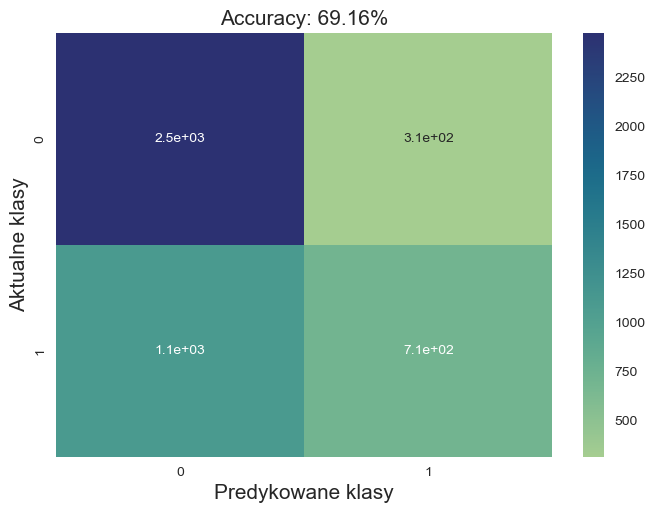

In [22]:
plot_confusion_matrix(y, y_pred_GD, accuracy_GD)

### Stochastic Gradient Descent:

Następnie zaimplementowany został algorytm Stochastic Gradient Descent, który od pierwotnej wersji różni się tym, że w ramach każdej epoki procesu uczenia zbiór danych jest najpierw losowo mieszany, a potem w pętli iteracyjnie jest wczytywany w postaci tzw. *batch'y* w celu aktualizacji parametrów hipotezy. Zastosowana implementacja poniżej:

In [23]:
def StochasticGradientDescent( in_X, in_y, in_theta, alpha=0.1, num_iter=50, batch_size=8 ):
    X = in_X.copy()
    y = in_y.copy()
    theta = in_theta.copy()
    X_len = X.shape[0]
    idx = np.arange(X_len)
    num_iter = math.ceil( num_iter/ (X_len/batch_size) )
    
    for _ in range(num_iter):
        idx_perm = np.random.permutation(idx)
        X, y = X[idx_perm], y[idx_perm]
        for start in range(0, X_len, batch_size):
            stop = start + batch_size
            J, dJ0, dJ = CostFunction( X[start:stop,:], y[start:stop], theta )
            theta[0] = theta[0] - alpha * dJ0.sum()
            theta[1:] = theta[1:] - alpha * dJ
    
    return theta, J

Co należy zauważyć to w powyższej implementacji *num_iter* odpowiada sumarycznej liczbie iteracji pętli wewnętrzej (kwestia lepszego performance'u).

Mając wszystko już przygotowane, przeprowadzonne zostały symulacje działania algorytmu:

In [24]:
print( 'Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o dostarczony inteface %timeit:' )
time_SGD = %timeit -r 3 -n 7 -o StochasticGradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER, BATCH_SIZE)
print( 'Przeprowadzono 3x7 wykonań kodu.' )

Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o dostarczony inteface %timeit:
90.5 ms ± 3.19 ms per loop (mean ± std. dev. of 3 runs, 7 loops each)
Przeprowadzono 3x7 wykonań kodu.


In [25]:
thetaOptSGD, JOptSGD = StochasticGradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER, BATCH_SIZE)

In [26]:
print( 'Znalezione minimum przez algorytm:', JOptSGD )

Znalezione minimum przez algorytm: 0.5245430799326735


In [27]:
y_pred_SGD = predict(X_norm, thetaOptSGD)

In [28]:
accuracy_SGD = get_accuracy(y, y_pred_SGD)
print( f'Policzona accuracy (dokładność): {accuracy_SGD:.6f}' )

Policzona accuracy (dokładność): 0.683330


Tablica pomyłek dla metody:


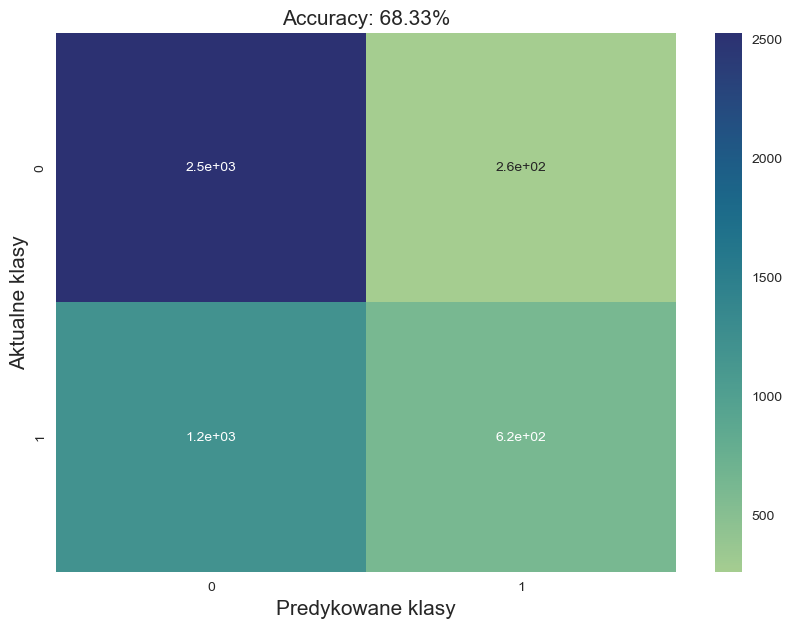

In [29]:
plot_confusion_matrix(y, y_pred_SGD, accuracy_SGD)

### Zastosowanie sampling'u:

*Undersampling* w analizie danych to techniki stosowane w celu dostosowania rozkładu klas w zbiorze danych (stosunku między różnymi reprezentowanymi klasami/kategoriami) lub też po prostu redukcji ilości danych, np. w celu przypsieszenia obliczeń, w pewnych przypadkach zmniejszenia redundancji.  
W kolejnych podejściu została zastosowana właśnie ta technika, dla celu zaimplementowania jakiej po prostu przeprowadzono uruchomienie algorytmu GD, który przeprowadził symulację dla odpowiednio zredukowawnego zbioru danych:

In [30]:
NUM_SAMPLES = int( m*SAMPLING_FRACTION )
idx_sampled = np.random.choice( m, size=NUM_SAMPLES, replace=False )

# check that each item occurs only once
print( "Czy próbki w nowym zbiorze powtarzają się:", ( np.bincount(idx_sampled.ravel()) == 1 ).all() )

Czy próbki w nowym zbiorze powtarzają się: False


In [31]:
X_sampled, y_sampled = X_norm[idx_sampled,:], y[idx_sampled]

Mając wszystko już przygotowane, przeprowadzonne zostały symulacje działania algorytmu:

In [32]:
print( 'Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o dostarczony inteface %timeit:' )
time_Sampl = %timeit -r 3 -n 7 -o GradientDescent(X_sampled, y_sampled, theta_0, ALPHA, NUM_ITER)
print( 'Przeprowadzono 3x7 wykonań kodu.' )

Uzyskano następujące pomiary czasowe, realizowane kilkutronie w oparciu o dostarczony inteface %timeit:
473 ms ± 34.5 ms per loop (mean ± std. dev. of 3 runs, 7 loops each)
Przeprowadzono 3x7 wykonań kodu.


In [33]:
thetaOptSampl, JOptSampl = GradientDescent(X_sampled, y_sampled, theta_0, ALPHA, NUM_ITER)

In [34]:
print( 'Znalezione minimum przez algorytm:', JOptSampl )

Znalezione minimum przez algorytm: 0.6223788963318766


In [35]:
y_pred_Sampl = predict(X_norm, thetaOptSampl)

In [36]:
accuracy_Sampl = get_accuracy(y, y_pred_Sampl)
print( f'Policzona accuracy (dokładność): {accuracy_Sampl:.6f}' )

Policzona accuracy (dokładność): 0.690285


Tablica pomyłek dla metody:


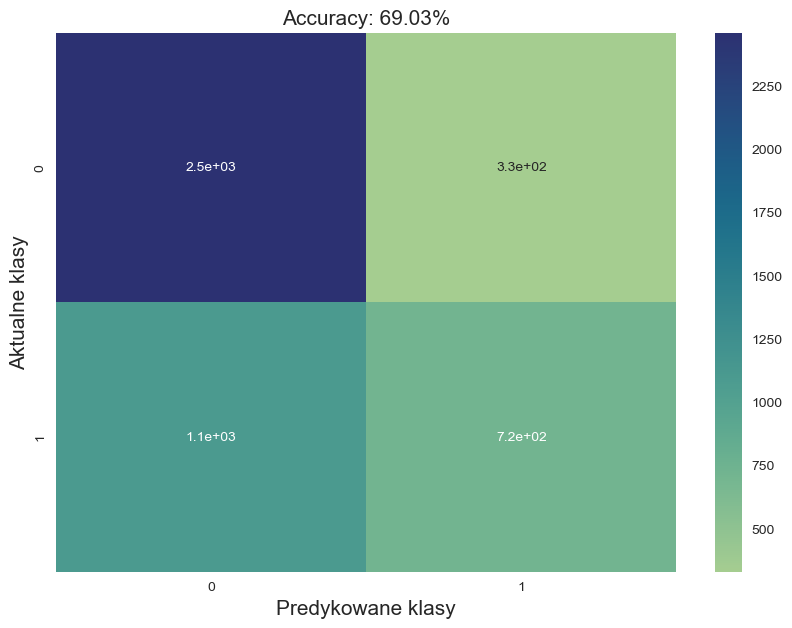

In [37]:
plot_confusion_matrix(y, y_pred_Sampl, accuracy_Sampl)

### Analiza przeprowadzonych symulacji:

W dalszej części przeprowadzono kolejne badania w celu pozyskania danych dla wizualizacji danych i ogólnych charaktarestyk procesów związanych z wydajnością zaimplementowanych algorytmów.  
Poniżej zamieszczono zmienione wersje funkcji *GradientDescent* i *StochasticGradientDescent*, napisanych dla celu zebrania danych koniecznych dla stworzenia odpowiednich wykresów. Oprócz nich zaimplementowano funkcje odpowiedzialne za generowanie wykresów.

In [38]:
def AnalyzeGradientDescent( X, y, in_theta, alpha=0.1, num_iter=50 ):
    theta = in_theta.copy()
    
    J_list = []
    theta_list = []
    
    for _ in range(num_iter):
        J, dJ0, dJ = CostFunction(X, y, theta)
        theta[0] = theta[0] - alpha * dJ0.sum()
        theta[1:] = theta[1:] - alpha * dJ
        J_list.append(J)
        theta_list.append(theta)
        
    return np.array(theta_list), np.array(J_list)

In [39]:
def AnalyzeStochasticGradientDescent( in_X, in_y, in_theta, alpha=0.1, num_iter=50, batch_size=8 ):
    X = in_X.copy()
    y = in_y.copy()
    theta = in_theta.copy()
    X_len = X.shape[0]
    idx = np.arange(X_len)
    num_iter = math.ceil( num_iter/ math.ceil(X_len/batch_size) )
    
    J_list = []
    theta_list = []
    
    for _ in range(num_iter):
        idx_perm = np.random.permutation(idx)
        X, y = X[idx_perm], y[idx_perm]
        for start in range(0, X_len, batch_size):
            stop = start + batch_size
            J, dJ0, dJ = CostFunction( X[start:stop,:], y[start:stop], theta )
            theta[0] = theta[0] - alpha * dJ0.sum()
            theta[1:] = theta[1:] - alpha * dJ
            J_list.append(J)
            theta_list.append(theta)
        
    return np.array(theta_list), np.array(J_list)

Poniżej wygenerowano wykresy zależności wartości funkcja kosztu od liczby iteracji dla poszczególnych algorytmów:

In [40]:
thetaOpt_list, JOpt_list = AnalyzeGradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER)

In [41]:
thetaOptSGD_list, JOptSGD_list = AnalyzeStochasticGradientDescent(
                            X_norm, y, theta_0, ALPHA, NUM_ITER, BATCH_SIZE
                        )

Dla SGD obserwowalne są ciągłe dynamiczne zmiany wartości funkcja kosztu, co jest skutkiem stochatycznego charaktery dodanych zmian do tego tego algorytmu względem GD.

In [42]:
thetaOptSampl_list, JOptSampl_list = AnalyzeGradientDescent(X_sampled, y_sampled, theta_0, ALPHA, NUM_ITER)

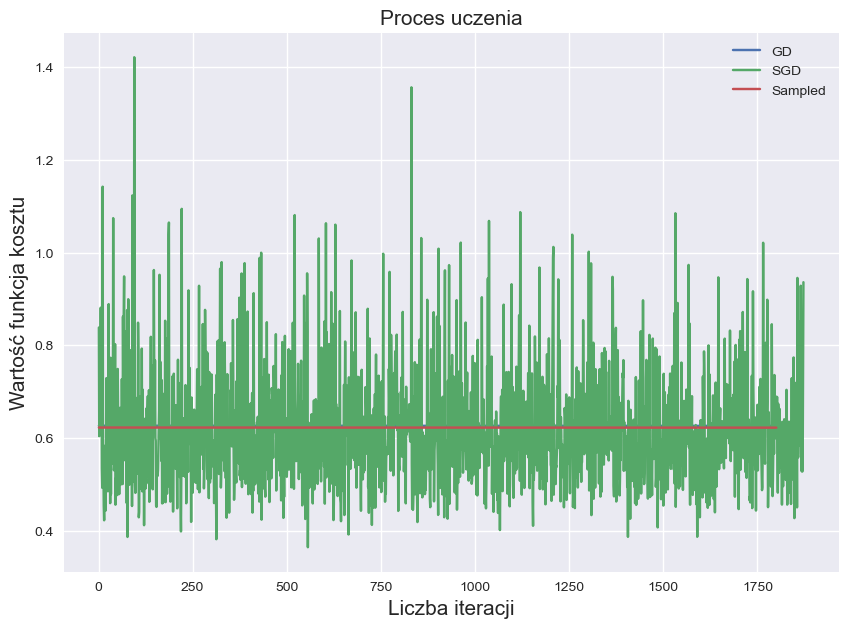

In [43]:
plt.plot(range(1, len(JOpt_list) + 1), JOpt_list, label='GD' )
plt.plot(range(1, len(JOptSGD_list) + 1), JOptSGD_list, label='SGD' )
plt.plot(range(1, len(JOptSampl_list) + 1), JOptSampl_list, label='Sampled' )
plt.xlabel('Liczba iteracji', size=15)
plt.ylabel('Wartość funkcja kosztu', size=15)
plt.title('Proces uczenia', size=15)
plt.legend( loc='best' )
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.show()

Poniżej wygenerowano wykresy zależności czasu dla poszczególnych algorytmów:

In [44]:
methods_names = ['GD', 'SGD', 'Sampled']

In [45]:
timings_GD = time_GD.timings[:]
timings_SGD = time_SGD.timings[:]
timings_Sampl = time_Sampl.timings[:]
timings = [timings_GD, timings_SGD, timings_Sampl]

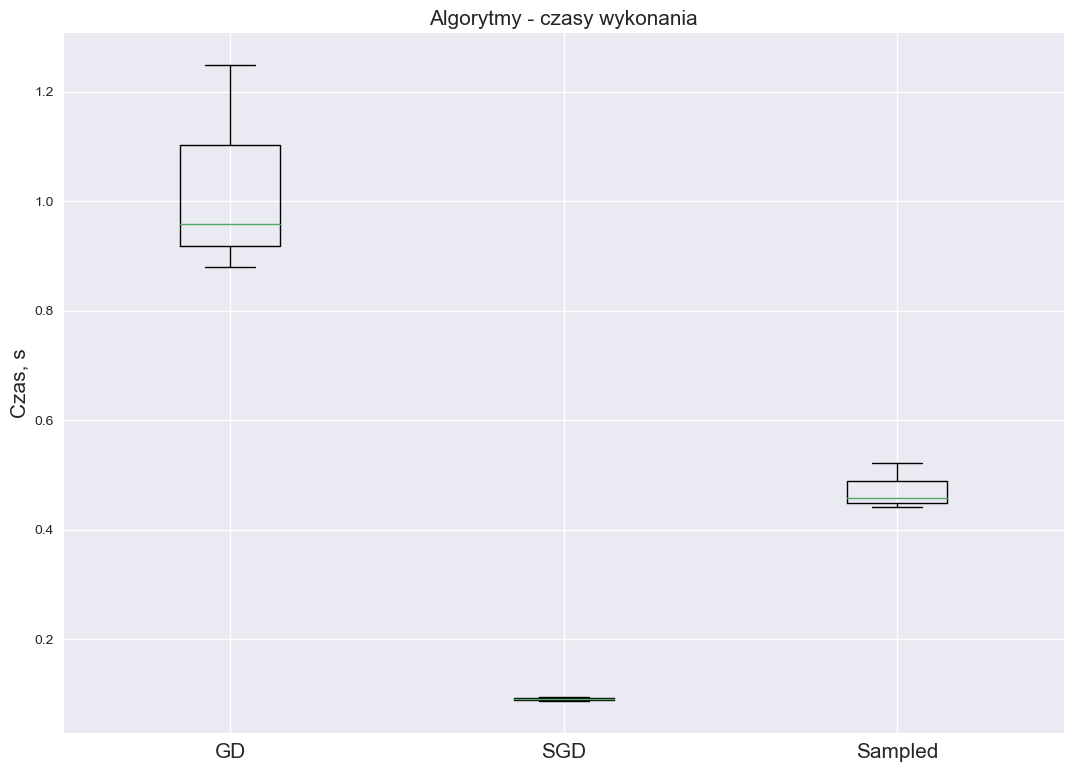

In [46]:
fig = plt.figure(figsize = (HEIGHT, WEIGHT))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(timings)
ax.set_title('Algorytmy - czasy wykonania', size=15)
ax.set_xticks([1, 2, 3], methods_names, size=15)
ax.set_ylabel('Czas, s', size=15)
plt.show()

In [47]:
print(f'Proporcja szybkości wykonania metody SGD do metody GD wyniosła {time_GD.best/time_SGD.best:.2f}:1, a do metody Sampled GD {time_Sampl.best/time_SGD.best:.2f}:1.')
print(f'Proporcja szybkości wykonania metody Sampled GD do metody GD wyniosła {time_GD.best/time_Sampl.best:.2f}:1.')

Proporcja szybkości wykonania metody SGD do metody GD wyniosła 10.19:1, a do metody Sampled GD 5.11:1.
Proporcja szybkości wykonania metody Sampled GD do metody GD wyniosła 1.99:1.


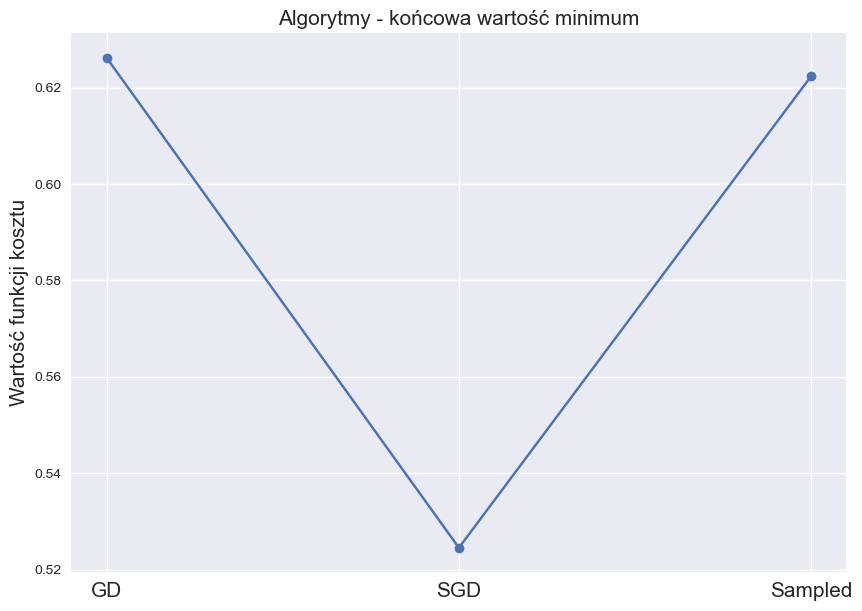

In [48]:
plt.plot([JOpt, JOptSGD, JOptSampl], '-o')
plt.title('Algorytmy - końcowa wartość minimum', size=15)
plt.xticks([0, 1, 2], methods_names, size=15)
plt.ylabel('Wartość funkcji kosztu', size=15)
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.show()

In [49]:
print(f'Proporcja dokładności metody SGD do metody GD wyniosła {accuracy_SGD/accuracy_GD:.5f}, a względem metody Sampled GD wyniosła {accuracy_SGD/accuracy_Sampl:.5f}.')
print('Jak można zauważyć różnice były niewielkie, ale co bardziej wynikało z charakteru dostarczonych danych.')

Proporcja dokładności metody SGD do metody GD wyniosła 0.98806, a względem metody Sampled GD wyniosła 0.98992.
Jak można zauważyć różnice były niewielkie, ale co bardziej wynikało z charakteru dostarczonych danych.


#### Obserwacje:

* Jak można na tym etapie zauważyć to SGD uzyskał lepsze wyniki pod względem wydajności czasowej i precyzji względem pozostałych rozwiązań.

### Testy dla hipotez $\theta_{1}$ i $\theta_{2}$

W celu dokonania zbadania działania algorytmów dla innych zadanych (wygenerowanych) hipotez bądź też ich potencjalnego wpływu na jakość wyników, przeprowadziłem symulacje dla dwóch kolejnych hipotez $\theta_{1}$ i $\theta_{2}$.

In [50]:
theta_1 = np.random.rand(n+1)
print('Hipoteza:\n', theta_1[:])

Hipoteza:
 [0.48793691 0.54186846 0.94957449 0.68637937 0.03975577 0.38222384
 0.8969842  0.05097261 0.35682095 0.41110458 0.1447173  0.84142398
 0.91954292 0.95985369 0.81699066 0.99147092 0.98305283 0.14955027
 0.87923361 0.99577048 0.24543057 0.80383347 0.68934622 0.90123521
 0.88544566 0.66484459 0.27980471 0.78455803 0.30029405 0.04212817
 0.75339555 0.48612397 0.96024746 0.58673026 0.19282889 0.9750681
 0.81296487 0.9062287  0.83911873 0.33792246 0.4011804  0.48090821
 0.3755806  0.32263306 0.79657744 0.01500876 0.65344118 0.83228922
 0.55295772 0.25862041 0.01531894 0.20377517 0.20692997 0.07520467
 0.31743764 0.52102658 0.55526856 0.95914262]


In [51]:
time_GD = %timeit -r 3 -n 7 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

1 s ± 103 ms per loop (mean ± std. dev. of 3 runs, 7 loops each)


In [52]:
thetaOpt, JOpt = GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [53]:
y_pred_GD = predict(X_norm, thetaOpt)
accuracy_GD = get_accuracy(y, y_pred_GD)
print( f'Policzona accuracy (dokładność): {accuracy_GD:.6f}' )

Policzona accuracy (dokładność): 0.698978


In [54]:
time_SGD = %timeit -r 3 -n 7 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

915 ms ± 34.5 ms per loop (mean ± std. dev. of 3 runs, 7 loops each)


In [55]:
thetaOptSGD, JOptSGD = StochasticGradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER, BATCH_SIZE)

In [56]:
y_pred_SGD = predict(X_norm, thetaOptSGD)
accuracy_SGD = get_accuracy(y, y_pred_SGD)
print( f'Policzona accuracy (dokładność): {accuracy_SGD:.6f}' )

Policzona accuracy (dokładność): 0.698978


In [57]:
time_Sampl = %timeit -r 3 -n 7 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

928 ms ± 10.1 ms per loop (mean ± std. dev. of 3 runs, 7 loops each)


In [58]:
thetaOptSampl, JOptSampl = GradientDescent(X_sampled, y_sampled, theta_1, ALPHA, NUM_ITER)

In [59]:
y_pred_Sampl = predict(X_norm, thetaOptSampl)
accuracy_Sampl = get_accuracy(y, y_pred_Sampl)
print( f'Policzona accuracy (dokładność): {accuracy_Sampl:.6f}' )

Policzona accuracy (dokładność): 0.698326


In [60]:
timings_GD = time_GD.timings[:]
timings_SGD = time_SGD.timings[:]
timings_Sampl = time_Sampl.timings[:]
timings = [timings_GD, timings_SGD, timings_Sampl]

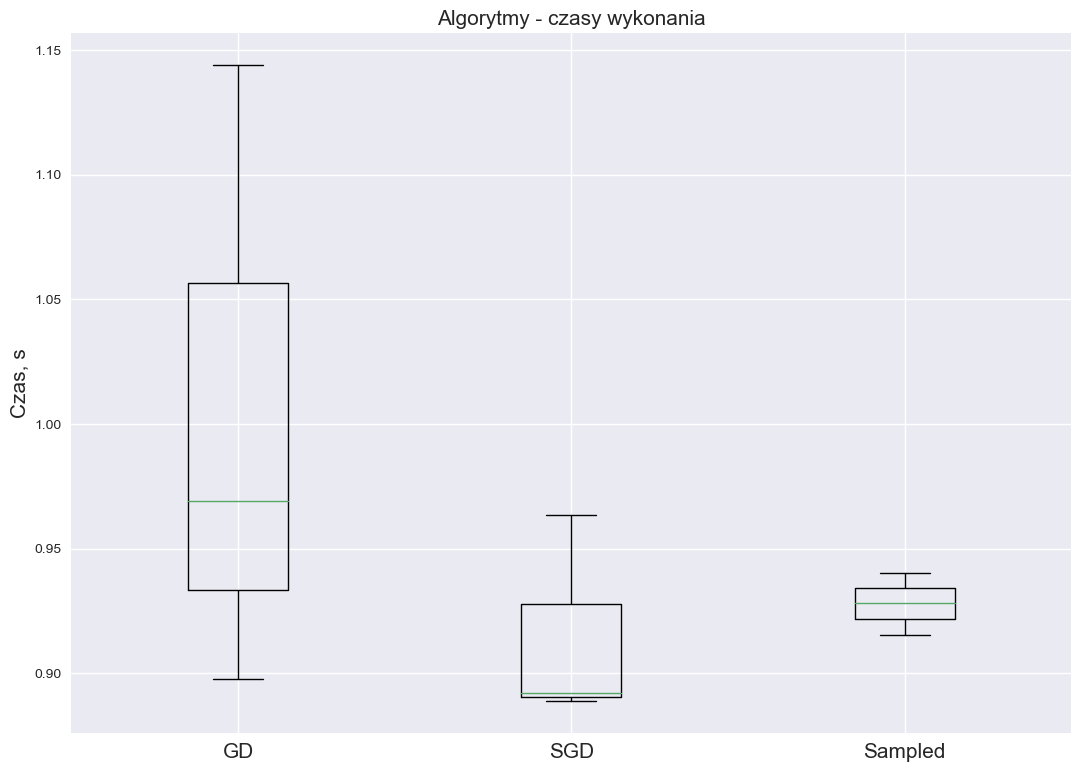

In [61]:
fig = plt.figure(figsize = (HEIGHT, WEIGHT))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(timings)
ax.set_title('Algorytmy - czasy wykonania', size=15)
ax.set_xticks([1, 2, 3], methods_names, size=15)
ax.set_ylabel('Czas, s', size=15)
plt.show()

In [62]:
print(f'Proporcja szybkości wykonania metody SGD do metody GD wyniosła {time_GD.best/time_SGD.best:.2f}:1, a do metody Sampled GD {time_Sampl.best/time_SGD.best:.2f}:1.')
print(f'Proporcja szybkości wykonania metody Sampled GD do metody GD wyniosła {time_GD.best/time_Sampl.best:.2f}:1.')

Proporcja szybkości wykonania metody SGD do metody GD wyniosła 1.01:1, a do metody Sampled GD 1.03:1.
Proporcja szybkości wykonania metody Sampled GD do metody GD wyniosła 0.98:1.


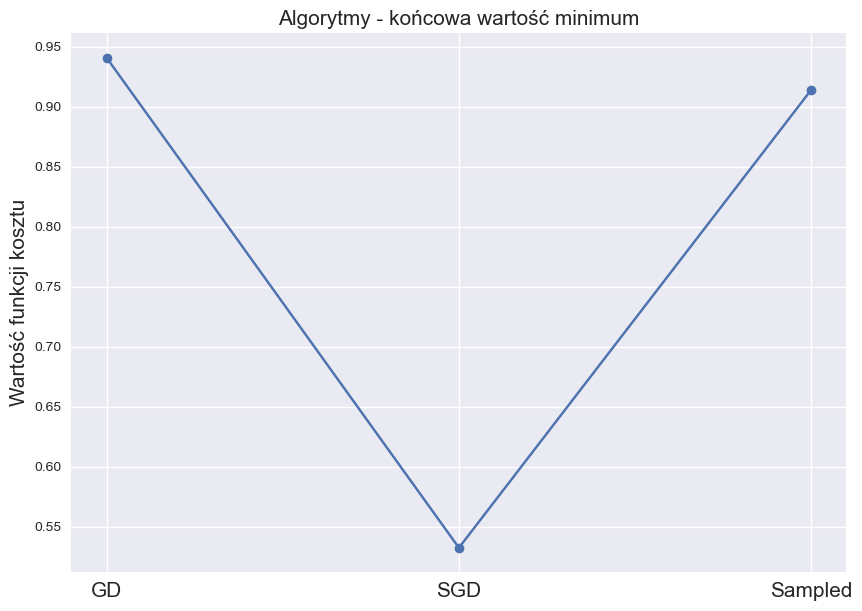

In [63]:
plt.plot([JOpt, JOptSGD, JOptSampl], '-o')
plt.title('Algorytmy - końcowa wartość minimum', size=15)
plt.xticks([0, 1, 2], methods_names, size=15)
plt.ylabel('Wartość funkcji kosztu', size=15)
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.show()

In [64]:
print(f'Proporcja dokładności metody SGD do metody GD wyniosła {accuracy_SGD/accuracy_GD:.5f}, a względem metody Sampled GD wyniosła {accuracy_SGD/accuracy_Sampl:.5f}.')
print('Jak można zauważyć różnice były niewielkie, ale co bardziej wynikało z charakteru dostarczonych danych.')

Proporcja dokładności metody SGD do metody GD wyniosła 1.00000, a względem metody Sampled GD wyniosła 1.00093.
Jak można zauważyć różnice były niewielkie, ale co bardziej wynikało z charakteru dostarczonych danych.


In [65]:
theta_2 = np.random.rand(n+1)
print('Hipoteza:\n', theta_2[:])

Hipoteza:
 [0.73519985 0.63632414 0.86419709 0.91914614 0.52200504 0.90708959
 0.59686275 0.08200492 0.87269808 0.8926599  0.74119    0.11367941
 0.48081405 0.62316821 0.7457596  0.97927914 0.27492067 0.66678898
 0.71488674 0.11677833 0.73168361 0.74430274 0.85218629 0.35215039
 0.17869471 0.17474224 0.86951339 0.38668797 0.56193028 0.56452047
 0.39230169 0.29994102 0.37836652 0.37739362 0.49480162 0.80262195
 0.7876121  0.30542357 0.81793541 0.50147599 0.75789598 0.35962663
 0.91997336 0.18869336 0.50853715 0.90294019 0.32075247 0.44483674
 0.71809273 0.37540918 0.86418617 0.71734151 0.65049308 0.0846656
 0.23592777 0.33574064 0.72401366 0.82824435]


In [66]:
time_GD = %timeit -r 3 -n 7 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

1.05 s ± 195 ms per loop (mean ± std. dev. of 3 runs, 7 loops each)


In [67]:
thetaOpt, JOpt = GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [68]:
y_pred_GD = predict(X_norm, thetaOpt)
accuracy_GD = get_accuracy(y, y_pred_GD)
print( f'Policzona accuracy (dokładność): {accuracy_GD:.6f}' )

Policzona accuracy (dokładność): 0.698978


In [69]:
time_SGD = %timeit -r 3 -n 7 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

892 ms ± 2.37 ms per loop (mean ± std. dev. of 3 runs, 7 loops each)


In [70]:
thetaOptSGD, JOptSGD = StochasticGradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER, BATCH_SIZE)

In [71]:
y_pred_SGD = predict(X_norm, thetaOptSGD)
accuracy_SGD = get_accuracy(y, y_pred_SGD)
print( f'Policzona accuracy (dokładność): {accuracy_SGD:.6f}' )

Policzona accuracy (dokładność): 0.698761


In [72]:
time_Sampl = %timeit -r 3 -n 7 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

894 ms ± 8.39 ms per loop (mean ± std. dev. of 3 runs, 7 loops each)


In [73]:
thetaOptSampl, JOptSampl = GradientDescent(X_sampled, y_sampled, theta_1, ALPHA, NUM_ITER)

In [74]:
y_pred_Sampl = predict(X_norm, thetaOptSampl)
accuracy_Sampl = get_accuracy(y, y_pred_Sampl)
print( f'Policzona accuracy (dokładność): {accuracy_Sampl:.6f}' )

Policzona accuracy (dokładność): 0.698326


In [75]:
timings_GD = time_GD.timings[:]
timings_SGD = time_SGD.timings[:]
timings_Sampl = time_Sampl.timings[:]
timings = [timings_GD, timings_SGD, timings_Sampl]

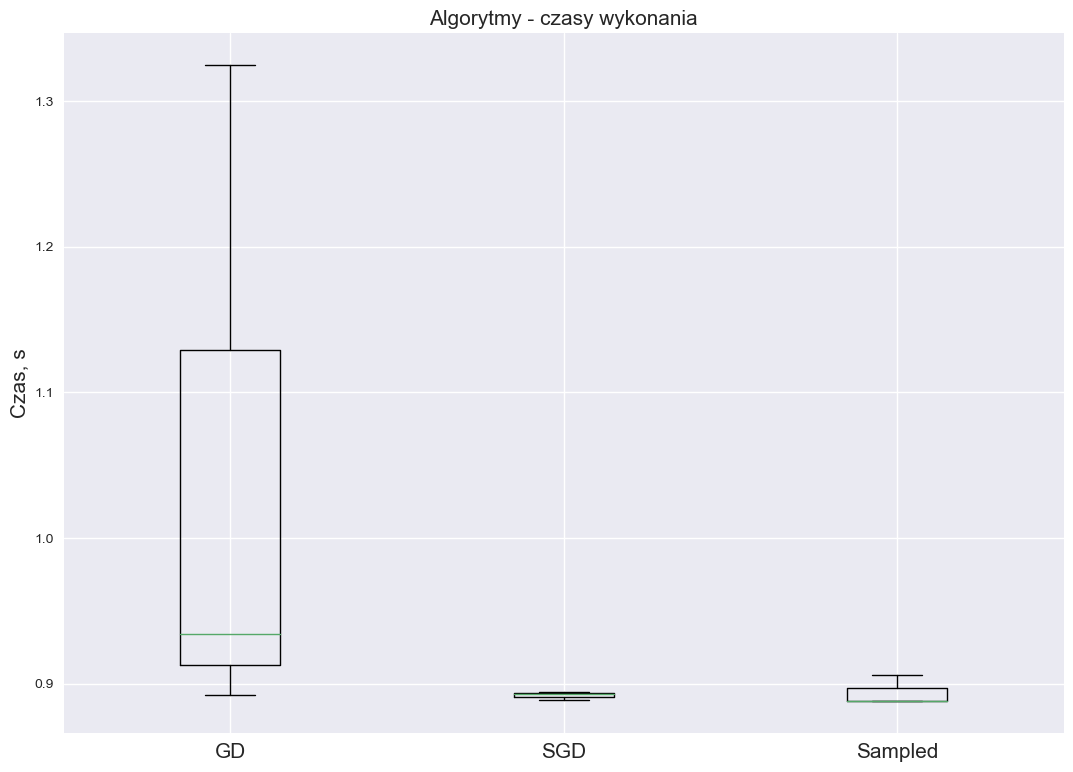

In [76]:
fig = plt.figure(figsize = (HEIGHT, WEIGHT))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(timings)
ax.set_title('Algorytmy - czasy wykonania', size=15)
ax.set_xticks([1, 2, 3], methods_names, size=15)
ax.set_ylabel('Czas, s', size=15)
plt.show()

In [77]:
print(f'Proporcja szybkości wykonania metody SGD do metody GD wyniosła {time_GD.best/time_SGD.best:.2f}:1, a do metody Sampled GD {time_Sampl.best/time_SGD.best:.2f}:1.')
print(f'Proporcja szybkości wykonania metody Sampled GD do metody GD wyniosła {time_GD.best/time_Sampl.best:.2f}:1.')

Proporcja szybkości wykonania metody SGD do metody GD wyniosła 1.00:1, a do metody Sampled GD 1.00:1.
Proporcja szybkości wykonania metody Sampled GD do metody GD wyniosła 1.01:1.


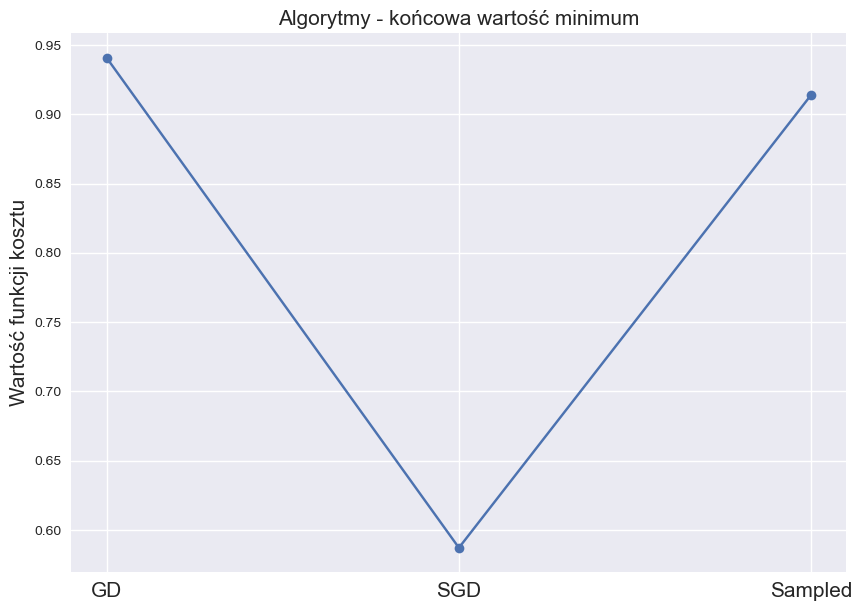

In [78]:
plt.plot([JOpt, JOptSGD, JOptSampl], '-o')
plt.title('Algorytmy - końcowa wartość minimum', size=15)
plt.xticks([0, 1, 2], methods_names, size=15)
plt.ylabel('Wartość funkcji kosztu', size=15)
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.show()

In [79]:
print(f'Proporcja dokładności metody SGD do metody GD wyniosła {accuracy_SGD/accuracy_GD:.5f}, a względem metody Sampled GD wyniosła {accuracy_SGD/accuracy_Sampl:.5f}.')
print('Jak można zauważyć różnice były niewielkie, ale co bardziej wynikało z charakteru dostarczonych danych.')

Proporcja dokładności metody SGD do metody GD wyniosła 0.99969, a względem metody Sampled GD wyniosła 1.00062.
Jak można zauważyć różnice były niewielkie, ale co bardziej wynikało z charakteru dostarczonych danych.


## Wnioski:
* Metoda SGD okazała się być metodą mogącą być porównywalną (prypadek hipotezy $\theta_{2}$) lub kilkukrotnie, nawet ponad 10-krotnie, szybszą od GD i Sampled GD.
* Dla wszystkich prypadków metoda SGD zwracała mniejsze wartości (minima lokalne), względem GD i Sampled GD.
* Generalnie metoda Sampled GD okazała się być metodą szybszą od metody GD- poza prypadkiem hipotezy $\theta_{2}$.
* Metody uzyskiwały podobną dokładność we wszystkich przypadkach - zależnie od hipotezy - z maksymalnymi różnicami dokładności na poziomie do 1%.
* Zbiór danych nie został dobrze przygotowany przez co trudne było uzyskanie dokładności na poziomie ok. 90%.
* Proces szukania rozwiązania u metody SGD charakteryzuje się zmiennością zwracanych rozwiązań w porównaniu z pozostałymi metodami.

## Referencje:

[1] A. Ng, "CS229. Lecture notes. Supervised learning", 2012, [na:] https://web.archive.org/web/20180618211933/http://cs229.stanford.edu/notes/cs229-notes1.pdf, [dostęp:] 21.01.2023.  
[2] A. Pant, "Introduction to Logistic Regression", 2019, [na:] https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148, [dostęp:] 24.01.2023.  
[3] https://archive.ics.uci.edu/ml/datasets/spambase, [dostęp:] 24.01.2023.  
[4] https://stackoverflow.com/a/29863846, [dostęp:] 21.01.2023.  
[5] https://realpython.com/gradient-descent-algorithm-python/, [dostęp:] 21.01.2023.  